# Corrosion Prediction for Pipeline

In [1]:
# 📦 1. Imports and Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans

# Optional: Use TensorFlow for NN
# import tensorflow as tf
# from tensorflow.keras import layers, models

# Set visuals
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [12]:
# 2. Generate Synthetic Data
try:
    # Attempt to load dataset from GitHub/Kaggle
    df = pd.read_csv('https://raw.githubusercontent.com/example/corrosion_dataset.csv')  # Replace with actual URL
    print("✅ Public dataset loaded.")
except:
    print("⚠️ Public dataset not available. Generating synthetic field data...")

    # Synthetic data generator
    np.random.seed(42)
    asset_type = 'downstream piping'
    fluid_types = ['oil', 'water', 'gas', 'mixture']
    material_types = ['carbon_steel', 'stainless_steel', 'alloy']

    df = pd.DataFrame({
        'temperature': np.random.uniform(40, 120, 1000),
        'pressure': np.random.uniform(10, 200, 1000),
        'flow_rate': np.random.uniform(100, 5000, 1000),
        'working_hours': np.random.uniform(0, 8760, 1000),
        'fluid_type': np.random.choice(fluid_types, 1000),
        'material_type': np.random.choice(material_types, 1000),
        'chemical_composition': np.random.uniform(0.1, 5.0, 1000),  # proxy for aggressiveness
    })

    # Simulate corrosion rate (mm/year)
    df['corrosion_rate'] = (
        0.02 * df['temperature'] +
        0.01 * df['pressure'] +
        0.003 * df['chemical_composition'] +
        np.where(df['material_type'] == 'carbon_steel', 0.5, 0.2) +
        np.random.normal(0, 0.2, 1000)
    )

⚠️ Public dataset not available. Generating synthetic field data...


In [8]:
# 3. Feature Engineering
# One-hot encode categorical features
df_encoded = pd.get_dummies(df, columns=['fluid_type', 'material_type'], drop_first=True)

# Add clustering feature
kmeans = KMeans(n_clusters=3, random_state=42)
df_encoded['cluster'] = kmeans.fit_predict(df_encoded[['temperature', 'pressure', 'flow_rate']])

# Dimensionality Reduction
features = df_encoded.drop('corrosion_rate', axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# Final dataset
X = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(5)])
y = df['corrosion_rate']

C:\Users\Luigi Saputelli\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [9]:
# 4. Train ML Model (Random Forest)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
print(f"🔍 RMSE: {rmse:.3f} mm/year")

🔍 RMSE: 0.230 mm/year


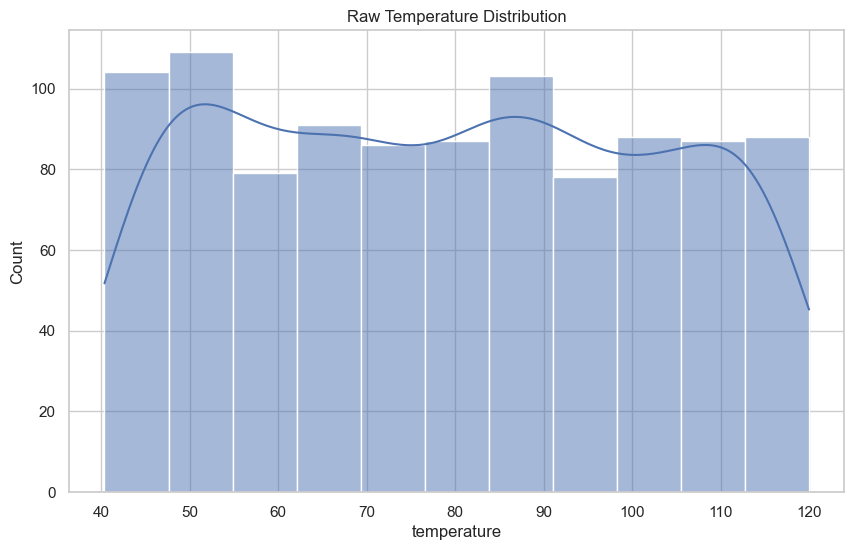

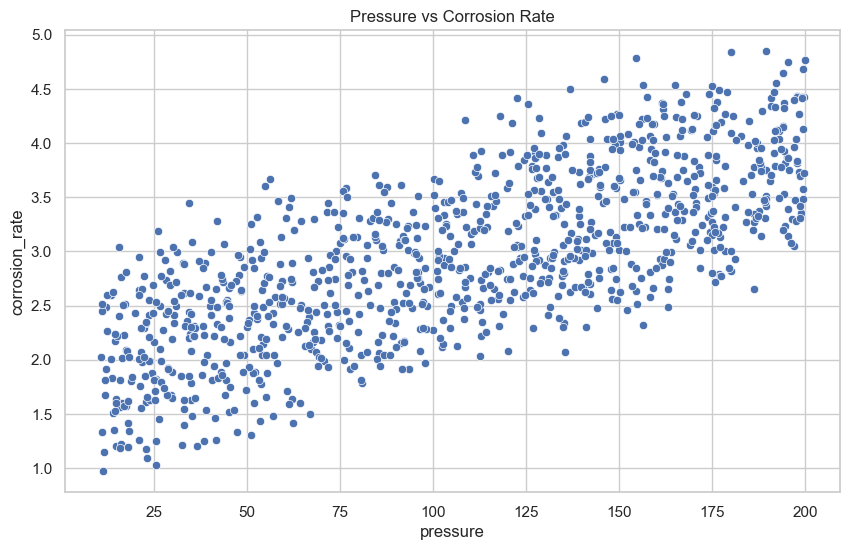

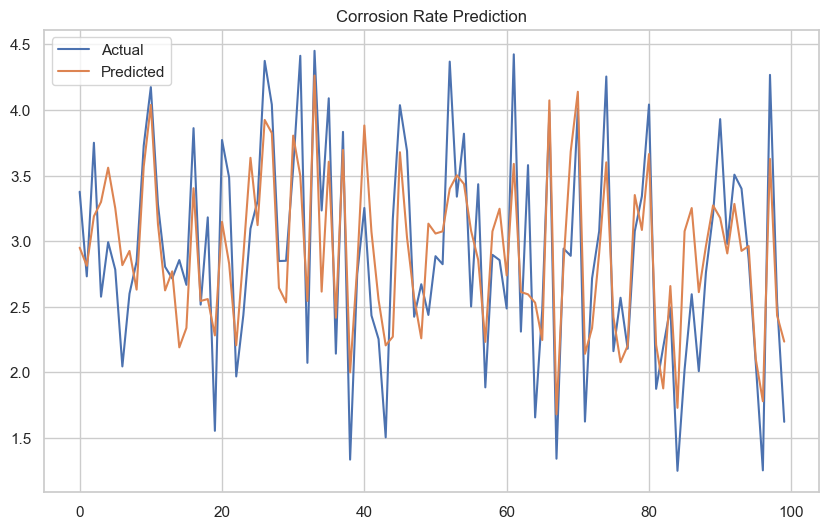

In [10]:
# 5. Visualization
# Raw vs cleaned
sns.histplot(df['temperature'], kde=True)
plt.title('Raw Temperature Distribution')
plt.show()

sns.scatterplot(x='pressure', y='corrosion_rate', data=df)
plt.title('Pressure vs Corrosion Rate')
plt.show()

# Predictions vs actual
plt.plot(y_test.values[:100], label='Actual')
plt.plot(y_pred[:100], label='Predicted')
plt.title('Corrosion Rate Prediction')
plt.legend()
plt.show()

In [11]:
# 6. Derived Outputs
df['prob_failure'] = np.clip(df['corrosion_rate'] / df['corrosion_rate'].max(), 0, 1)
df['remaining_life'] = np.maximum(5 - df['corrosion_rate'], 0)

# Display sample
df[['corrosion_rate', 'prob_failure', 'remaining_life']].head()

,corrosion_rate,prob_failure,remaining_life
0,2.384425,0.491883,2.615575
1,3.926069,0.809908,1.073931
2,3.843993,0.792977,1.156007
3,3.584751,0.739498,1.415249
4,2.749788,0.567253,2.250212
